<a href="https://colab.research.google.com/github/amarathe/ELEN521_labs/blob/master/Lab8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 8 
Ashwin Marathe, Sharanjeet Singh

1. Generate MNIST
2. Generate Pokemon

# 1. Generate MNIST

In [6]:
%tensorflow_version 2.0
%matplotlib inline

# 1. Take a look at:
# https://keras.io/examples/mnist_acgan/ (Links to an external site.)
#
# We will use a DCGAN to generate new pokemons or african fabric images
#
# Dataset are in:
#    https://www.kaggle.com/vishalsubbiah/pokemon-images-and-types

from __future__ import print_function

from collections import defaultdict
try:
    import cPickle as pickle
except ImportError:
    import pickle
from PIL import Image

from six.moves import range

import tensorflow
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2DTranspose, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Progbar
import numpy as np

np.random.seed(1337)
num_classes = 10


def build_generator(latent_size):
    # we will map a pair of (z, L), where z is a latent vector and L is a
    # label drawn from P_c, to image space (..., 28, 28, 1)
    cnn = Sequential()

    cnn.add(Dense(3 * 3 * 384, input_dim=latent_size, activation='relu'))
    cnn.add(Reshape((3, 3, 384)))

    # upsample to (7, 7, ...)
    cnn.add(Conv2DTranspose(192, 5, strides=1, padding='valid',
                            activation='relu',
                            kernel_initializer='glorot_normal'))
    cnn.add(BatchNormalization())

    # upsample to (14, 14, ...)
    cnn.add(Conv2DTranspose(96, 5, strides=2, padding='same',
                            activation='relu',
                            kernel_initializer='glorot_normal'))
    cnn.add(BatchNormalization())

    # upsample to (28, 28, ...)
    cnn.add(Conv2DTranspose(1, 5, strides=2, padding='same',
                            activation='tanh',
                            kernel_initializer='glorot_normal'))

    # this is the z space commonly referred to in GAN papers
    latent = Input(shape=(latent_size, ))

    # this will be our label
    image_class = Input(shape=(1,), dtype='int32')

    cls = Embedding(num_classes, latent_size,
                    embeddings_initializer='glorot_normal')(image_class)

    # hadamard product between z-space and a class conditional embedding
    h = layers.multiply([latent, cls])

    fake_image = cnn(h)

    return Model([latent, image_class], fake_image)


def build_discriminator():
    # build a relatively standard conv net, with LeakyReLUs as suggested in
    # the reference paper
    cnn = Sequential()

    cnn.add(Conv2D(32, 3, padding='same', strides=2,
                   input_shape=(28, 28, 1)))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(64, 3, padding='same', strides=1))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(128, 3, padding='same', strides=2))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(256, 3, padding='same', strides=1))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Flatten())

    image = Input(shape=(28, 28, 1))

    features = cnn(image)

    # first output (name=generation) is whether or not the discriminator
    # thinks the image that is being shown is fake, and the second output
    # (name=auxiliary) is the class that the discriminator thinks the image
    # belongs to.
    fake = Dense(1, activation='sigmoid', name='generation')(features)
    aux = Dense(num_classes, activation='softmax', name='auxiliary')(features)

    return Model(image, [fake, aux])


if __name__ == '__main__':
    # batch and latent size taken from the paper
    epochs = 4
    batch_size = 100
    latent_size = 100

    # Adam parameters suggested in https://arxiv.org/abs/1511.06434
    adam_lr = 0.0002
    adam_beta_1 = 0.5

    # build the discriminator
    print('Discriminator model:')
    discriminator = build_discriminator()
    discriminator.compile(
        optimizer=Adam(learning_rate=adam_lr, beta_1=adam_beta_1),
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
    )
    discriminator.summary()

    # build the generator
    generator = build_generator(latent_size)

    latent = Input(shape=(latent_size, ))
    image_class = Input(shape=(1,), dtype='int32')

    # get a fake image
    fake = generator([latent, image_class])

    # we only want to be able to train generation for the combined model
    discriminator.trainable = False
    fake, aux = discriminator(fake)
    combined = Model([latent, image_class], [fake, aux])

    print('Combined model:')
    combined.compile(
        optimizer=Adam(learning_rate=adam_lr, beta_1=adam_beta_1),
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
    )
    combined.summary()

    # get our mnist data, and force it to be of shape (..., 28, 28, 1) with
    # range [-1, 1]
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
#    print ("MNIST y_test[0]", y_test[0])
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5
    print ("x_train shape0 pre-expand:", x_train.shape)

    x_train = np.expand_dims(x_train, axis=-1)
    print ("x_train shape0:", x_train.shape)


    x_test = (x_test.astype(np.float32) - 127.5) / 127.5
    x_test = np.expand_dims(x_test, axis=-1)

    num_train, num_test = x_train.shape[0], x_test.shape[0]

    train_history = defaultdict(list)
    test_history = defaultdict(list)

    for epoch in range(1, epochs + 1):
        print('Epoch {}/{}'.format(epoch, epochs))

        num_batches = int(np.ceil(x_train.shape[0] / float(batch_size)))
        progress_bar = Progbar(target=num_batches)

        epoch_gen_loss = []
        epoch_disc_loss = []

        for index in range(num_batches):
            # get a batch of real images
            image_batch = x_train[index * batch_size:(index + 1) * batch_size]
            label_batch = y_train[index * batch_size:(index + 1) * batch_size]

            # generate a new batch of noise
            noise = np.random.uniform(-1, 1, (len(image_batch), latent_size))

            # sample some labels from p_c
            sampled_labels = np.random.randint(0, num_classes, len(image_batch))

            # generate a batch of fake images, using the generated labels as a
            # conditioner. We reshape the sampled labels to be
            # (len(image_batch), 1) so that we can feed them into the embedding
            # layer as a length one sequence
            generated_images = generator.predict(
                [noise, sampled_labels.reshape((-1, 1))], verbose=0)

            x = np.concatenate((image_batch, generated_images))

            # use one-sided soft real/fake labels
            # Salimans et al., 2016
            # https://arxiv.org/pdf/1606.03498.pdf (Section 3.4)
            soft_zero, soft_one = 0, 0.95
            y = np.array(
                [soft_one] * len(image_batch) + [soft_zero] * len(image_batch))
            aux_y = np.concatenate((label_batch, sampled_labels), axis=0)

            # we don't want the discriminator to also maximize the classification
            # accuracy of the auxiliary classifier on generated images, so we
            # don't train discriminator to produce class labels for generated
            # images (see https://openreview.net/forum?id=rJXTf9Bxg).
            # To preserve sum of sample weights for the auxiliary classifier,
            # we assign sample weight of 2 to the real images.
            disc_sample_weight = [np.ones(2 * len(image_batch)),
                                  np.concatenate((np.ones(len(image_batch)) * 2,
                                                  np.zeros(len(image_batch))))]

            # see if the discriminator can figure itself out...
            epoch_disc_loss.append(discriminator.train_on_batch(
                x, [y, aux_y], sample_weight=disc_sample_weight))

            # make new noise. we generate 2 * batch size here such that we have
            # the generator optimize over an identical number of images as the
            # discriminator
            noise = np.random.uniform(-1, 1, (2 * len(image_batch), latent_size))
            sampled_labels = np.random.randint(0, num_classes, 2 * len(image_batch))

            # we want to train the generator to trick the discriminator
            # For the generator, we want all the {fake, not-fake} labels to say
            # not-fake
            trick = np.ones(2 * len(image_batch)) * soft_one

            epoch_gen_loss.append(combined.train_on_batch(
                [noise, sampled_labels.reshape((-1, 1))],
                [trick, sampled_labels]))

            progress_bar.update(index + 1)

        print('Testing for epoch {}:'.format(epoch))

        # evaluate the testing loss here

        # generate a new batch of noise
        noise = np.random.uniform(-1, 1, (num_test, latent_size))

        # sample some labels from p_c and generate images from them
        sampled_labels = np.random.randint(0, num_classes, num_test)
        generated_images = generator.predict(
            [noise, sampled_labels.reshape((-1, 1))], verbose=False)

        x = np.concatenate((x_test, generated_images))
        y = np.array([1] * num_test + [0] * num_test)
        aux_y = np.concatenate((y_test, sampled_labels), axis=0)

        # see if the discriminator can figure itself out...
        discriminator_test_loss = discriminator.evaluate(
            x, [y, aux_y], verbose=False)

        discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)

        # make new noise
        noise = np.random.uniform(-1, 1, (2 * num_test, latent_size))
        sampled_labels = np.random.randint(0, num_classes, 2 * num_test)

        trick = np.ones(2 * num_test)

        generator_test_loss = combined.evaluate(
            [noise, sampled_labels.reshape((-1, 1))],
            [trick, sampled_labels], verbose=False)

        generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)

        # generate an epoch report on performance
        train_history['generator'].append(generator_train_loss)
        train_history['discriminator'].append(discriminator_train_loss)

        test_history['generator'].append(generator_test_loss)
        test_history['discriminator'].append(discriminator_test_loss)

        print('{0:<22s} | {1:4s} | {2:15s} | {3:5s}'.format(
            'component', *discriminator.metrics_names))
        print('-' * 65)

        ROW_FMT = '{0:<22s} | {1:<4.2f} | {2:<15.4f} | {3:<5.4f}'
        print(ROW_FMT.format('generator (train)',
                             *train_history['generator'][-1]))
        print(ROW_FMT.format('generator (test)',
                             *test_history['generator'][-1]))
        print(ROW_FMT.format('discriminator (train)',
                             *train_history['discriminator'][-1]))
        print(ROW_FMT.format('discriminator (test)',
                             *test_history['discriminator'][-1]))

        # save weights every epoch
        generator.save_weights(
            'params_generator_epoch_{0:03d}.hdf5'.format(epoch), True)
        discriminator.save_weights(
            'params_discriminator_epoch_{0:03d}.hdf5'.format(epoch), True)

        # generate some digits to display
        num_rows = 40
        noise = np.tile(np.random.uniform(-1, 1, (num_rows, latent_size)),
                        (num_classes, 1))

        sampled_labels = np.array([
            [i] * num_rows for i in range(num_classes)
        ]).reshape(-1, 1)

        # get a batch to display
        generated_images = generator.predict(
            [noise, sampled_labels], verbose=0)

        # prepare real images sorted by class label
        real_labels = y_train[(epoch - 1) * num_rows * num_classes:
                              epoch * num_rows * num_classes]
        indices = np.argsort(real_labels, axis=0)
        real_images = x_train[(epoch - 1) * num_rows * num_classes:
                              epoch * num_rows * num_classes][indices]

        # display generated images, white separator, real images
        img = np.concatenate(
            (generated_images,
             np.repeat(np.ones_like(x_train[:1]), num_rows, axis=0),
             real_images))

        # arrange them into a grid
        #print ("img shape:", img.shape)

        img = (np.concatenate([r.reshape(-1, 28)
                               for r in np.split(img, 2 * num_classes + 1)
                               ], axis=-1) * 127.5 + 127.5).astype(np.uint8)

        Image.fromarray(img).save(
            'plot_epoch_{0:03d}_generated.png'.format(epoch))

    with open('acgan-history.pkl', 'wb') as f:
        pickle.dump({'train': train_history, 'test': test_history}, f)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.0`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
Discriminator model:
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 12544)        387840      input_11[0][0]                   
__________________________________________________________________________________________________
generation (Dense)              (None, 1)            12545       sequential_4[1][0]               
_______________________________________________________________________

KeyboardInterrupt: ignored

plot_epoch_001_generated.png  plot_epoch_008_generated.png
plot_epoch_002_generated.png  plot_epoch_009_generated.png
plot_epoch_003_generated.png  plot_epoch_010_generated.png
plot_epoch_004_generated.png  plot_epoch_011_generated.png
plot_epoch_005_generated.png  plot_epoch_012_generated.png
plot_epoch_006_generated.png  plot_epoch_013_generated.png
plot_epoch_007_generated.png


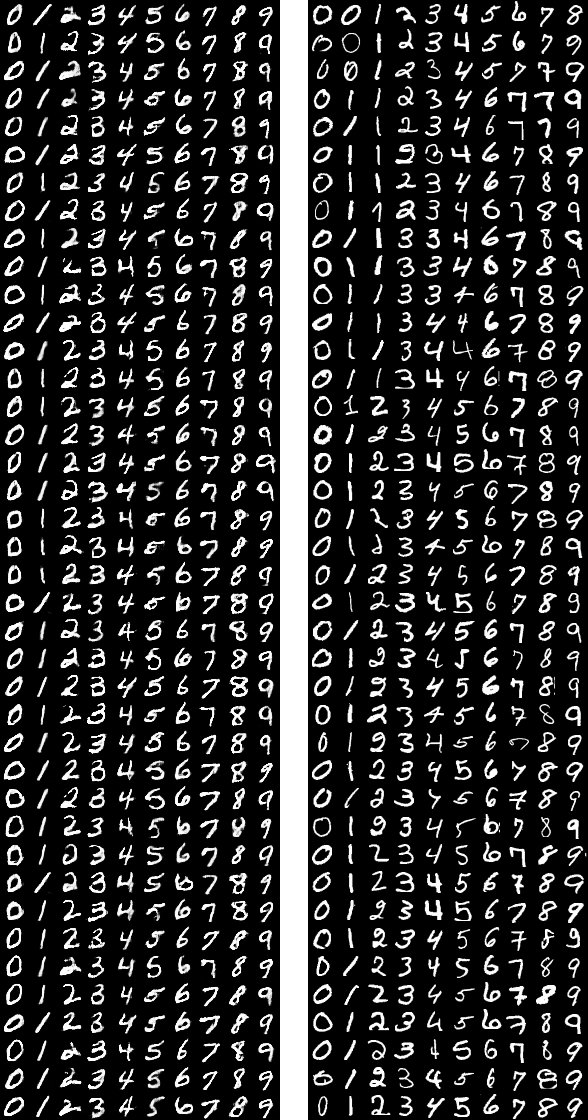

In [43]:
!ls *.png
from IPython.display import Image
Image(filename='plot_epoch_013_generated.png') 

# 2. Generate Pokemon

In [3]:
from os import path


#Instructions for getting dataset from kaggle:
# https://medium.com/@saedhussain/google-colaboratory-and-kaggle-datasets-b57a83eb6ef8
from google.colab import files
!pip install -q kaggle
#Upload your kaggle.json API file

if not path.exists("/root/.kaggle/kaggle.json"): 
  firsttime = True
  uploaded = files.upload()
  !mkdir ~/.kaggle
  !mv kaggle.json ~/.kaggle/kaggle.json
  !ls -halt ~/.kaggle
  !chmod 600 ~/.kaggle/kaggle.json

if firsttime: 
  !kaggle datasets download -d vishalsubbiah/pokemon-images-and-types

import zipfile
if not path.exists("pokemon-images-and-types"):
  with zipfile.ZipFile("pokemon-images-and-types.zip","r") as zip_ref:
    zip_ref.extractall("pokemon-images-and-types")

#!ls

Saving kaggle.json to kaggle.json
total 16K
drwxr-xr-x 2 root root 4.0K Mar 25 07:04 .
drwx------ 1 root root 4.0K Mar 25 07:04 ..
-rw-r--r-- 1 root root   64 Mar 25 07:04 kaggle.json
  0% 0.00/2.47M [00:00<?, ?B/s]
100% 2.47M/2.47M [00:00<00:00, 81.5MB/s]


In [0]:
#!ls pokemon-images-and-types/images/images

In [36]:
!ls pokemon-images-and-types

import csv
with open('pokemon-images-and-types/pokemon.csv', newline='') as csvfile:
  reader = csv.DictReader(csvfile)
  pokemons2type = {}

  for row in reader:
    pokemons2type[row['Name']] = row['Type1']
  
types_pokemon = list(set(pokemons2type.values()))
print ("Number of types:", len(types_pokemon))
print ("Types:", ", ".join(types_pokemon))

#Integer to type of pokemon mapping for categorization
int2type = {}
type2int = {}
for i in range(len(types_pokemon)):
  int2type[i] = types_pokemon[i]
  type2int[types_pokemon[i]] = i

import glob
imagepath = 'pokemon-images-and-types/images/images/'
images = glob.glob(imagepath + '*.png')

#from sklearn.datasets import fetch_openml
#imagedata = fetch_openml('Pokemon', data_home=imagepath)
#print ("type imagedata:", type(imagedata))
#print ("imagedata[0]", imagedata[0])

import cv2
import re
import sklearn.model_selection

x_data, y_data = [], []

import pprint 
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(int2type)

imagesizes = set()
for i, image in enumerate(images):
  im = cv2.imread(image)
#  print ("image:", re.sub(".*\/","", image))
#  print (type(im))
  imagesizes.add(im.shape)
  x_data.append(im)
  name = re.sub(".*\/","", image)
  name = re.sub(".png", "", name)
  y_data.append(type2int[pokemons2type[name]])
  if not i: print ("First pokemon:", image)

#Don't need to categorize as script will do it later
#y_data = tensorflow.keras.utils.to_categorical(y_data)

#Check shape of images
print("imagesizes:", imagesizes)
#Check 1 image to see if it matches label
print ("x_data[0].shape", x_data[0].shape)
print ("y_data[0]:", y_data[0])

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x_data, y_data)


images	pokemon.csv
Number of types: 18
Types: Steel, Grass, Water, Electric, Bug, Fighting, Flying, Dragon, Fairy, Psychic, Ghost, Ice, Fire, Normal, Poison, Ground, Rock, Dark
{   0: 'Steel',
    1: 'Grass',
    2: 'Water',
    3: 'Electric',
    4: 'Bug',
    5: 'Fighting',
    6: 'Flying',
    7: 'Dragon',
    8: 'Fairy',
    9: 'Psychic',
    10: 'Ghost',
    11: 'Ice',
    12: 'Fire',
    13: 'Normal',
    14: 'Poison',
    15: 'Ground',
    16: 'Rock',
    17: 'Dark'}
First pokemon: pokemon-images-and-types/images/images/cresselia.png
imagesizes: {(120, 120, 3)}
x_data[0].shape (120, 120, 3)
y_data[0]: 9


Discriminator model:
Model: "model_51"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_86 (InputLayer)           [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
sequential_34 (Sequential)      (None, 230400)       388416      input_86[0][0]                   
__________________________________________________________________________________________________
generation (Dense)              (None, 1)            230401      sequential_34[1][0]              
__________________________________________________________________________________________________
auxiliary (Dense)               (None, 18)           4147218     sequential_34[1][0]              
Total params: 4,766,035
Trainable params: 4,766,035
Non-trainable para

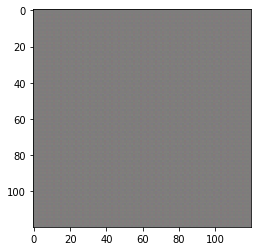

Epoch 2/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 92ms/step
Testing for epoch 2:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 3.09 | 0.3032          | 2.8722
generator (test)       | 8.73 | 5.7654          | 2.9566
discriminator (train)  | 2.67 | 0.1084          | 2.5723
discriminator (test)   | 2.89 | 0.0559          | 2.8391
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


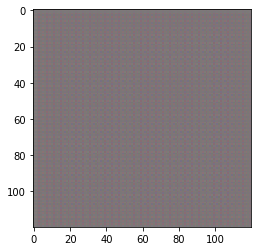

Epoch 3/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 92ms/step
Testing for epoch 3:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 2.94 | 0.3232          | 2.7123
generator (test)       | 9.42 | 6.5185          | 2.9044
discriminator (train)  | 2.36 | 0.1070          | 2.2612
discriminator (test)   | 2.98 | 0.1339          | 2.8525
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


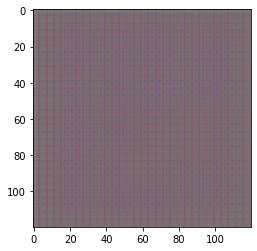

Epoch 4/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 93ms/step
Testing for epoch 4:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 2.63 | 0.3366          | 2.4116
generator (test)       | 9.36 | 6.4576          | 2.8957
discriminator (train)  | 1.96 | 0.1088          | 1.8713
discriminator (test)   | 3.03 | 0.1631          | 2.8601
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


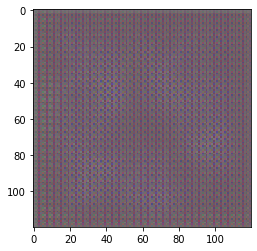

Epoch 5/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 93ms/step
Testing for epoch 5:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 2.11 | 0.3632          | 1.8675
generator (test)       | 6.39 | 3.5696          | 2.8166
discriminator (train)  | 1.46 | 0.1118          | 1.3706
discriminator (test)   | 3.12 | 0.1038          | 3.0059
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


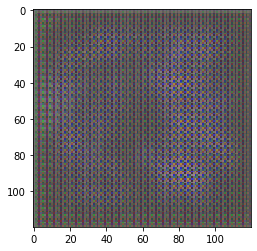

Epoch 6/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 93ms/step
Testing for epoch 6:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.77 | 0.4310          | 1.4224
generator (test)       | 7.89 | 5.1257          | 2.8164
discriminator (train)  | 1.05 | 0.1599          | 0.9272
discriminator (test)   | 3.27 | 0.0833          | 3.1447
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


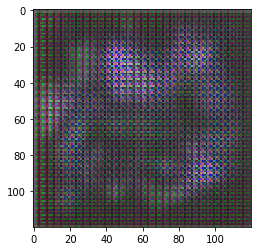

Epoch 7/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 93ms/step
Testing for epoch 7:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.14 | 0.4099          | 0.8509
generator (test)       | 6.76 | 4.4061          | 2.3601
discriminator (train)  | 0.69 | 0.1192          | 0.6143
discriminator (test)   | 3.35 | 0.0962          | 3.2005
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


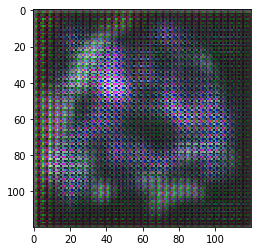

Epoch 8/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 92ms/step
Testing for epoch 8:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.10 | 0.5516          | 0.6498
generator (test)       | 13.06 | 10.9911         | 2.1113
discriminator (train)  | 0.48 | 0.1658          | 0.3627
discriminator (test)   | 3.52 | 0.1378          | 3.2945
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


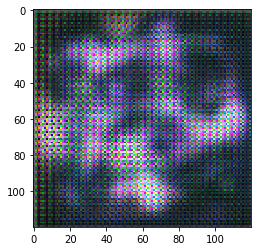

Epoch 9/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 6s 102ms/step
Testing for epoch 9:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.04 | 0.6227          | 0.6195
generator (test)       | 11.69 | 9.8105          | 1.9241
discriminator (train)  | 0.33 | 0.1600          | 0.2221
discriminator (test)   | 3.51 | 0.1333          | 3.2328
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


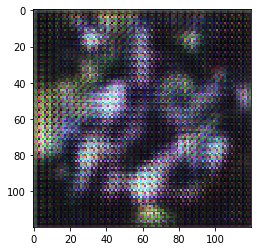

Epoch 10/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 93ms/step
Testing for epoch 10:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 7.31 | 4.9996          | 2.4951
generator (test)       | 16.33 | 9.3459          | 6.9550
discriminator (train)  | 0.84 | 0.5572          | 0.3348
discriminator (test)   | 5.33 | 0.0244          | 5.4213
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


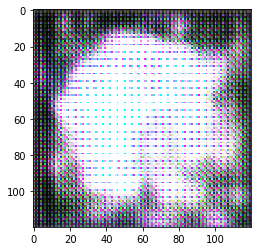

Epoch 11/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 94ms/step
Testing for epoch 11:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 2.76 | 1.4487          | 1.5352
generator (test)       | 6.16 | 4.1054          | 2.0792
discriminator (train)  | 0.38 | 0.2562          | 0.2088
discriminator (test)   | 3.44 | 0.3803          | 3.0038
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


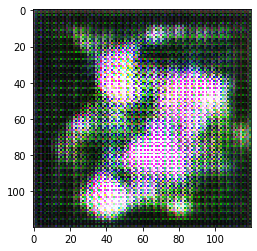

Epoch 12/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 93ms/step
Testing for epoch 12:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.53 | 0.6079          | 0.9777
generator (test)       | 3.51 | 2.5855          | 0.8937
discriminator (train)  | 0.34 | 0.2431          | 0.1381
discriminator (test)   | 2.74 | 0.1491          | 2.4755
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


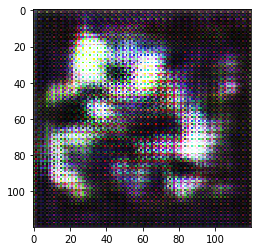

Epoch 13/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 93ms/step
Testing for epoch 13:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 3.12 | 2.4471          | 0.7129
generator (test)       | 7.68 | 4.8261          | 2.8192
discriminator (train)  | 0.38 | 0.3143          | 0.1018
discriminator (test)   | 4.07 | 0.4022          | 3.5227
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


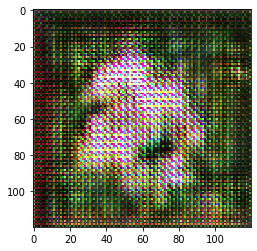

Epoch 14/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 94ms/step
Testing for epoch 14:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.45 | 0.5697          | 0.9472
generator (test)       | 4.63 | 4.1483          | 0.4521
discriminator (train)  | 0.39 | 0.2830          | 0.1515
discriminator (test)   | 2.51 | 0.0459          | 2.3483
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


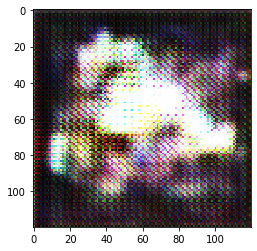

Epoch 15/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 93ms/step
Testing for epoch 15:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 0.78 | 0.5212          | 0.3291
generator (test)       | 3.03 | 2.4487          | 0.6312
discriminator (train)  | 0.23 | 0.1886          | 0.0807
discriminator (test)   | 2.74 | 0.1944          | 2.4326
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


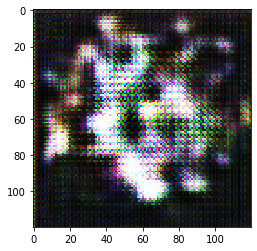

Epoch 16/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 92ms/step
Testing for epoch 16:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 4.76 | 3.6775          | 1.1216
generator (test)       | 1.46 | 0.3445          | 1.1063
discriminator (train)  | 0.83 | 0.7552          | 0.1133
discriminator (test)   | 3.23 | 1.1038          | 2.1389
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


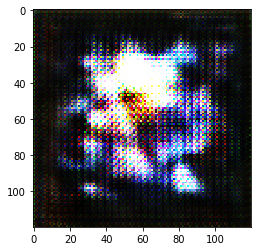

Epoch 17/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 93ms/step
Testing for epoch 17:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.34 | 0.6936          | 0.6126
generator (test)       | 3.36 | 2.8765          | 0.4619
discriminator (train)  | 0.43 | 0.3362          | 0.1344
discriminator (test)   | 2.42 | 0.1100          | 2.2319
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


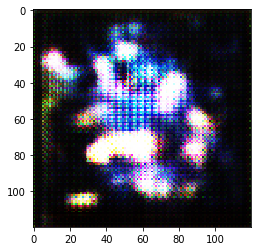

Epoch 18/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 93ms/step
Testing for epoch 18:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 5.62 | 4.4087          | 1.2612
generator (test)       | 2.36 | 1.4731          | 0.8829
discriminator (train)  | 0.72 | 0.6448          | 0.1040
discriminator (test)   | 2.70 | 0.5257          | 2.0669
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


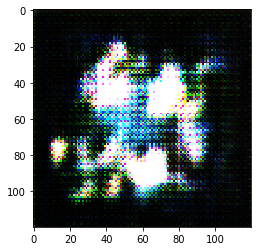

Epoch 19/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 94ms/step
Testing for epoch 19:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 2.75 | 1.9921          | 0.7547
generator (test)       | 3.09 | 2.2563          | 0.7613
discriminator (train)  | 0.80 | 0.6929          | 0.1396
discriminator (test)   | 2.53 | 0.3791          | 2.0905
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


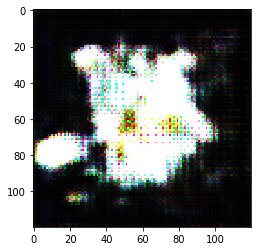

Epoch 20/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 93ms/step
Testing for epoch 20:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 3.29 | 2.4912          | 0.7946
generator (test)       | 1.54 | 0.3807          | 1.1601
discriminator (train)  | 0.83 | 0.7422          | 0.1207
discriminator (test)   | 3.48 | 1.0571          | 2.4213
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


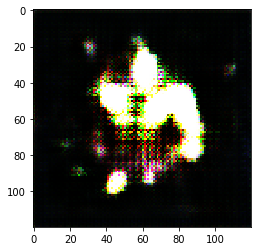

Epoch 21/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 92ms/step
Testing for epoch 21:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.11 | 0.7323          | 0.3662
generator (test)       | 2.57 | 2.1650          | 0.3813
discriminator (train)  | 0.51 | 0.4444          | 0.1109
discriminator (test)   | 2.37 | 0.1635          | 2.1123
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


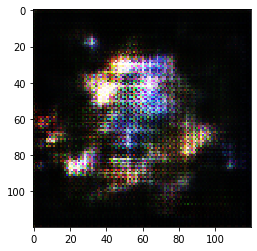

Epoch 22/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 93ms/step
Testing for epoch 22:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 3.35 | 2.9106          | 0.4742
generator (test)       | 13.25 | 11.3030         | 1.9325
discriminator (train)  | 0.37 | 0.3408          | 0.0638
discriminator (test)   | 3.50 | 0.2207          | 3.1409
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


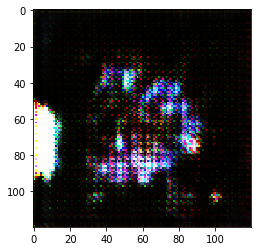

Epoch 23/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 92ms/step
Testing for epoch 23:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 2.62 | 1.9216          | 0.7299
generator (test)       | 1.45 | 0.4190          | 1.0130
discriminator (train)  | 0.68 | 0.6118          | 0.1021
discriminator (test)   | 3.19 | 0.8381          | 2.2896
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


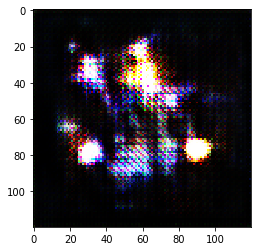

Epoch 24/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 92ms/step
Testing for epoch 24:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 2.46 | 2.0235          | 0.4490
generator (test)       | 3.69 | 2.6208          | 1.0751
discriminator (train)  | 0.67 | 0.5994          | 0.1113
discriminator (test)   | 2.88 | 0.2436          | 2.5488
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


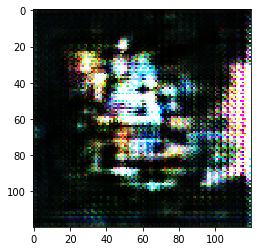

Epoch 25/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 93ms/step
Testing for epoch 25:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 0.81 | 0.5466          | 0.2761
generator (test)       | 6.79 | 6.0453          | 0.7189
discriminator (train)  | 0.22 | 0.1755          | 0.0803
discriminator (test)   | 2.57 | 0.0412          | 2.4532
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


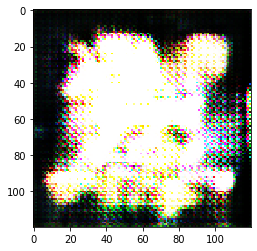

Epoch 26/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 92ms/step
Testing for epoch 26:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.88 | 1.6908          | 0.3005
generator (test)       | 0.81 | 0.2116          | 0.5716
discriminator (train)  | 0.58 | 0.5483          | 0.0713
discriminator (test)   | 3.13 | 1.0353          | 2.0253
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


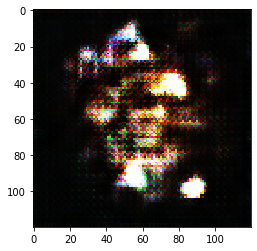

Epoch 27/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 92ms/step
Testing for epoch 27:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 3.79 | 3.3042          | 0.4599
generator (test)       | 1.29 | 0.6631          | 0.6218
discriminator (train)  | 0.65 | 0.6050          | 0.0782
discriminator (test)   | 3.09 | 0.6476          | 2.3781
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


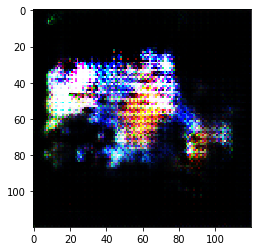

Epoch 28/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 92ms/step
Testing for epoch 28:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.83 | 1.4652          | 0.3649
generator (test)       | 1.36 | 0.9330          | 0.4397
discriminator (train)  | 0.47 | 0.4408          | 0.0741
discriminator (test)   | 2.94 | 0.7236          | 2.1593
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


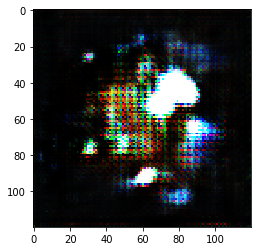

Epoch 29/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 93ms/step
Testing for epoch 29:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.97 | 1.6570          | 0.3172
generator (test)       | 0.40 | 0.1045          | 0.2927
discriminator (train)  | 0.69 | 0.6428          | 0.0760
discriminator (test)   | 3.51 | 1.4716          | 2.0122
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


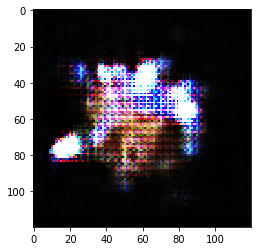

Epoch 30/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 93ms/step
Testing for epoch 30:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.84 | 1.5945          | 0.2358
generator (test)       | 1.03 | 0.2968          | 0.7317
discriminator (train)  | 0.69 | 0.6622          | 0.0728
discriminator (test)   | 3.31 | 1.0729          | 2.1373
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


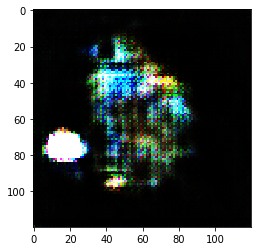

Epoch 31/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 93ms/step
Testing for epoch 31:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 2.15 | 1.8714          | 0.2698
generator (test)       | 0.97 | 0.5744          | 0.4061
discriminator (train)  | 0.79 | 0.7421          | 0.0804
discriminator (test)   | 2.95 | 0.8674          | 1.9841
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


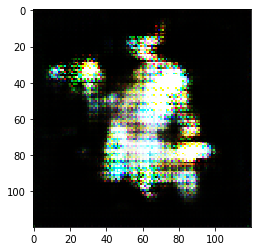

Epoch 32/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 93ms/step
Testing for epoch 32:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.60 | 1.3815          | 0.2159
generator (test)       | 0.29 | 0.1106          | 0.1731
discriminator (train)  | 0.72 | 0.6774          | 0.0742
discriminator (test)   | 3.47 | 1.5376          | 1.8834
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


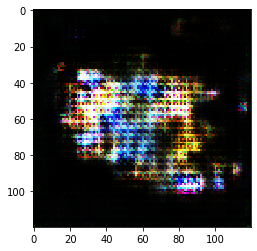

Epoch 33/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 6s 102ms/step
Testing for epoch 33:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.61 | 1.3849          | 0.1923
generator (test)       | 1.16 | 0.8409          | 0.3089
discriminator (train)  | 0.71 | 0.6786          | 0.0706
discriminator (test)   | 2.62 | 0.5651          | 1.9586
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


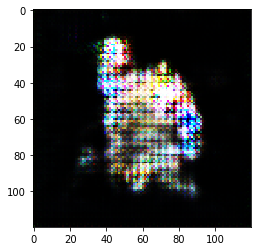

Epoch 34/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 93ms/step
Testing for epoch 34:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.73 | 1.5093          | 0.2249
generator (test)       | 0.60 | 0.3312          | 0.2531
discriminator (train)  | 0.69 | 0.6614          | 0.0641
discriminator (test)   | 2.96 | 0.9578          | 1.9348
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


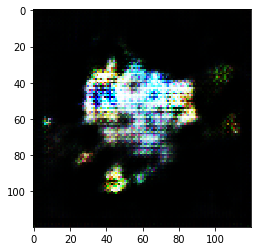

Epoch 35/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 92ms/step
Testing for epoch 35:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.72 | 1.4266          | 0.2501
generator (test)       | 1.81 | 1.5322          | 0.2787
discriminator (train)  | 0.67 | 0.6396          | 0.0695
discriminator (test)   | 2.99 | 0.9381          | 1.9071
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


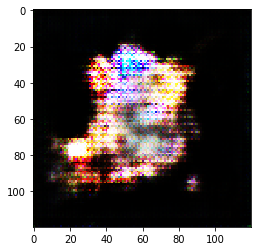

Epoch 36/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 92ms/step
Testing for epoch 36:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.59 | 1.3969          | 0.2098
generator (test)       | 1.79 | 1.3868          | 0.3821
discriminator (train)  | 0.68 | 0.6447          | 0.0650
discriminator (test)   | 3.13 | 0.8537          | 2.1204
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


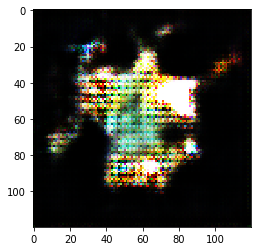

Epoch 37/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 93ms/step
Testing for epoch 37:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.59 | 1.4176          | 0.1740
generator (test)       | 2.08 | 1.8762          | 0.2080
discriminator (train)  | 0.60 | 0.5678          | 0.0621
discriminator (test)   | 2.76 | 0.5670          | 2.0442
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


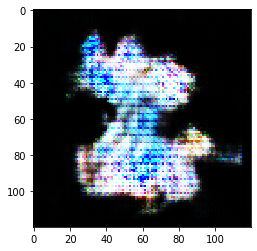

Epoch 38/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 92ms/step
Testing for epoch 38:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.53 | 1.3493          | 0.1813
generator (test)       | 2.96 | 2.8045          | 0.1580
discriminator (train)  | 0.63 | 0.6006          | 0.0642
discriminator (test)   | 2.61 | 0.4384          | 2.0305
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


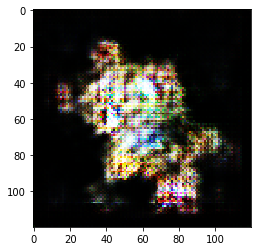

Epoch 39/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 93ms/step
Testing for epoch 39:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.19 | 1.0627          | 0.1607
generator (test)       | 2.03 | 1.8401          | 0.1890
discriminator (train)  | 0.55 | 0.5168          | 0.0626
discriminator (test)   | 2.65 | 0.5251          | 2.0081
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


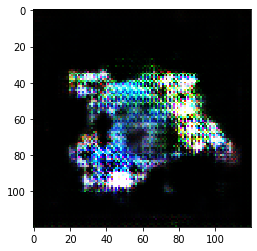

Epoch 40/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 93ms/step
Testing for epoch 40:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.54 | 1.4151          | 0.1488
generator (test)       | 2.41 | 0.9706          | 1.4138
discriminator (train)  | 0.61 | 0.5857          | 0.0559
discriminator (test)   | 3.59 | 0.7132          | 2.9060
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


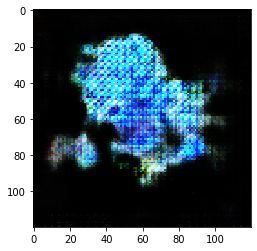

Epoch 41/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 92ms/step
Testing for epoch 41:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.35 | 1.1728          | 0.1852
generator (test)       | 2.24 | 2.1179          | 0.1187
discriminator (train)  | 0.58 | 0.5552          | 0.0791
discriminator (test)   | 2.48 | 0.3374          | 2.0187
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


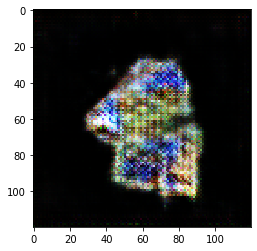

Epoch 42/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 93ms/step
Testing for epoch 42:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.34 | 1.2135          | 0.1519
generator (test)       | 1.80 | 1.4453          | 0.3503
discriminator (train)  | 0.52 | 0.5003          | 0.0580
discriminator (test)   | 2.71 | 0.4469          | 2.1488
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


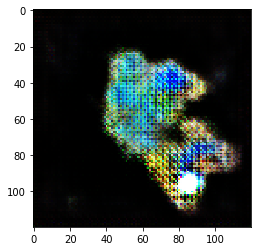

Epoch 43/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 93ms/step
Testing for epoch 43:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.74 | 1.5510          | 0.1743
generator (test)       | 2.36 | 2.1502          | 0.2305
discriminator (train)  | 0.60 | 0.5693          | 0.0605
discriminator (test)   | 2.69 | 0.4462          | 2.1061
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


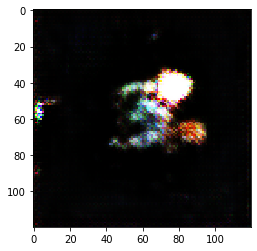

Epoch 44/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 94ms/step
Testing for epoch 44:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.47 | 1.2950          | 0.1778
generator (test)       | 2.34 | 2.2119          | 0.1369
discriminator (train)  | 0.51 | 0.4858          | 0.0567
discriminator (test)   | 2.47 | 0.3507          | 1.9899
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


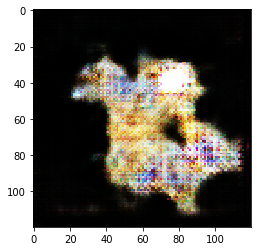

Epoch 45/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 94ms/step
Testing for epoch 45:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.54 | 1.4155          | 0.1432
generator (test)       | 2.13 | 1.8228          | 0.2950
discriminator (train)  | 0.57 | 0.5476          | 0.0574
discriminator (test)   | 2.82 | 0.5052          | 2.1762
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


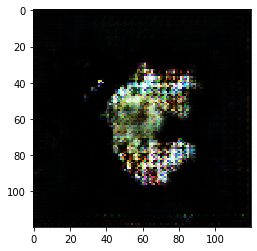

Epoch 46/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 93ms/step
Testing for epoch 46:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.67 | 1.4729          | 0.1802
generator (test)       | 2.71 | 2.4442          | 0.2535
discriminator (train)  | 0.50 | 0.4851          | 0.0550
discriminator (test)   | 3.03 | 0.7486          | 2.1538
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


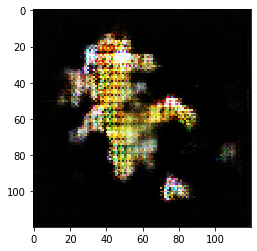

Epoch 47/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 92ms/step
Testing for epoch 47:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.57 | 1.4438          | 0.1551
generator (test)       | 1.56 | 0.9306          | 0.6158
discriminator (train)  | 0.51 | 0.4960          | 0.0558
discriminator (test)   | 3.40 | 0.8504          | 2.3969
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


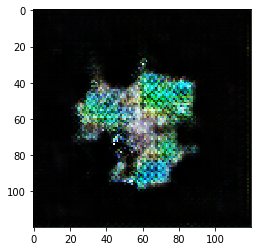

Epoch 48/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 92ms/step
Testing for epoch 48:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.62 | 1.4130          | 0.1840
generator (test)       | 2.23 | 2.1008          | 0.1289
discriminator (train)  | 0.57 | 0.5567          | 0.0587
discriminator (test)   | 2.99 | 0.6667          | 2.1637
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


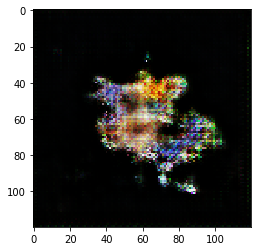

Epoch 49/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 93ms/step
Testing for epoch 49:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.43 | 1.2575          | 0.1950
generator (test)       | 2.59 | 2.5167          | 0.0998
discriminator (train)  | 0.57 | 0.5578          | 0.0529
discriminator (test)   | 2.77 | 0.6238          | 1.9991
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


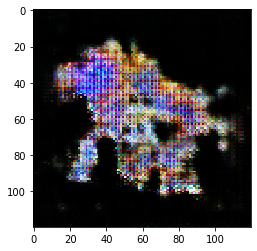

Epoch 50/50
x_train size for image_batch: (540, 120, 120, 3)
54/54 [==============================] - 5s 93ms/step
Testing for epoch 50:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.64 | 1.4911          | 0.1745
generator (test)       | 1.72 | 1.5751          | 0.1658
discriminator (train)  | 0.60 | 0.5885          | 0.0520
discriminator (test)   | 2.69 | 0.5683          | 2.0023
x_train real_images shape: (540, 120, 120, 3)
img shape: (370, 120, 120, 3)
np.split(img, 2 * num_classes + 1)[0].shape (10, 120, 120, 3)
shape img: (1200, 4440, 3)


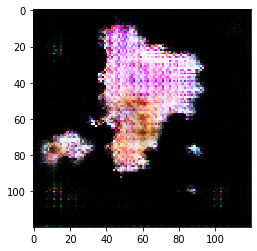

In [37]:
from __future__ import print_function

from collections import defaultdict
try:
    import cPickle as pickle
except ImportError:
    import pickle
from PIL import Image

from six.moves import range

import tensorflow
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2DTranspose, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Progbar
import numpy as np

np.random.seed(1337)
num_classes = len(types_pokemon)


def build_generator(latent_size):
    # we will map a pair of (z, L), where z is a latent vector and L is a
    # label drawn from P_c, to image space (..., 28, 28, 1)
    cnn = Sequential()

    #cnn.add(Dense(3 * 3 * 384, input_dim=latent_size, activation='relu'))
    #cnn.add(Reshape((3, 3, 384)))
    cnn.add(Dense(26 * 26 * 384, input_dim=latent_size, activation='relu'))
    cnn.add(Reshape((26, 26, 384)))

    # upsample to (7, 7, ...)
    # upsample to (30, 30, 3)
    cnn.add(Conv2DTranspose(192, 5, strides=1, padding='valid',
                            activation='relu',
                            kernel_initializer='glorot_normal'))
    cnn.add(BatchNormalization())

    # upsample to (14, 14, ...)
    # upsample to (60, 60, 3)
    cnn.add(Conv2DTranspose(96, 5, strides=2, padding='same',
                            activation='relu',
                            kernel_initializer='glorot_normal'))
    cnn.add(BatchNormalization())

    # upsample to (28, 28, ...)
    # upsample to (120, 120, 3)
    cnn.add(Conv2DTranspose(3, 5, strides=2, padding='same',
                            activation='tanh',
                            kernel_initializer='glorot_normal'))

    # this is the z space commonly referred to in GAN papers
    latent = Input(shape=(latent_size, ))

    # this will be our label
    image_class = Input(shape=(1,), dtype='int32')

    cls = Embedding(num_classes, latent_size,
                    embeddings_initializer='glorot_normal')(image_class)

    # hadamard product between z-space and a class conditional embedding
    h = layers.multiply([latent, cls])

    fake_image = cnn(h)

    return Model([latent, image_class], fake_image)


def build_discriminator():
    # build a relatively standard conv net, with LeakyReLUs as suggested in
    # the reference paper
    cnn = Sequential()

    cnn.add(Conv2D(32, 3, padding='same', strides=2,
                   input_shape=(120, 120, 3)))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(64, 3, padding='same', strides=1))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(128, 3, padding='same', strides=2))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(256, 3, padding='same', strides=1))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Flatten())

    image = Input(shape=(120, 120, 3))

    features = cnn(image)

    # first output (name=generation) is whether or not the discriminator
    # thinks the image that is being shown is fake, and the second output
    # (name=auxiliary) is the class that the discriminator thinks the image
    # belongs to.
    fake = Dense(1, activation='sigmoid', name='generation')(features)
    aux = Dense(num_classes, activation='softmax', name='auxiliary')(features)

    return Model(image, [fake, aux])


if __name__ == '__main__':
    # batch and latent size taken from the paper
    epochs = 50
#    batch_size = 100
#    batch_size = 10
    batch_size=25
    latent_size = 100

    # Adam parameters suggested in https://arxiv.org/abs/1511.06434
    adam_lr = 0.0002
    adam_beta_1 = 0.5

    # build the discriminator
    print('Discriminator model:')
    discriminator = build_discriminator()
    discriminator.compile(
        optimizer=Adam(learning_rate=adam_lr, beta_1=adam_beta_1),
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
    )
    discriminator.summary()

    # build the generator
    generator = build_generator(latent_size)
    print ("Generator summary:")
    generator.summary()

    latent = Input(shape=(latent_size, ))
    image_class = Input(shape=(1,), dtype='int32')

    # get a fake image
    fake = generator([latent, image_class])

    # we only want to be able to train generation for the combined model
    discriminator.trainable = False
    fake, aux = discriminator(fake)
    combined = Model([latent, image_class], [fake, aux])

    print('Combined model:')
    combined.compile(
        optimizer=Adam(learning_rate=adam_lr, beta_1=adam_beta_1),
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
    )
    combined.summary()

    # get our mnist data, and force it to be of shape (..., 28, 28, 1) with
    # range [-1, 1]
    #(x_train, y_train), (x_test, y_test) = mnist.load_data()
    #print ("type x_train", type(x_train))
    #print ("len(x_train):", len(x_train))
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    #print ("numpy x_train shape:", x_train.shape)
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5
    #x_train = np.expand_dims(x_train, axis=-1)
    #print ("x_train shape1:", x_train.shape)

    x_test = (x_test.astype(np.float32) - 127.5) / 127.5
    #x_test = np.expand_dims(x_test, axis=-1)

    num_train, num_test = x_train.shape[0], x_test.shape[0]

    train_history = defaultdict(list)
    test_history = defaultdict(list)

    for epoch in range(1, epochs + 1):
        print('Epoch {}/{}'.format(epoch, epochs))

        num_batches = int(np.ceil(x_train.shape[0] / float(batch_size)))
        progress_bar = Progbar(target=num_batches)

        epoch_gen_loss = []
        epoch_disc_loss = []

        for index in range(num_batches):
            # get a batch of real images
            print ("x_train size for image_batch:", x_train.shape)
            image_batch = x_train[index * batch_size:(index + 1) * batch_size]
            label_batch = y_train[index * batch_size:(index + 1) * batch_size]

            # generate a new batch of noise
            noise = np.random.uniform(-1, 1, (len(image_batch), latent_size))

            # sample some labels from p_c
            sampled_labels = np.random.randint(0, num_classes, len(image_batch))

            # generate a batch of fake images, using the generated labels as a
            # conditioner. We reshape the sampled labels to be
            # (len(image_batch), 1) so that we can feed them into the embedding
            # layer as a length one sequence
            generated_images = generator.predict(
                [noise, sampled_labels.reshape((-1, 1))], verbose=0)
 
            #print ("image_batch size:", image_batch.shape)
            #print ("generated_images size:", generated_images.shape)
            x = np.concatenate((image_batch, generated_images))


            # use one-sided soft real/fake labels
            # Salimans et al., 2016
            # https://arxiv.org/pdf/1606.03498.pdf (Section 3.4)
            soft_zero, soft_one = 0, 0.95
            y = np.array(
                [soft_one] * len(image_batch) + [soft_zero] * len(image_batch))
            #print ("y_test shape:", y_test.shape)
            #print ("sampled_labels shape:", sampled_labels.shape)
            aux_y = np.concatenate((label_batch, sampled_labels), axis=0)

            # we don't want the discriminator to also maximize the classification
            # accuracy of the auxiliary classifier on generated images, so we
            # don't train discriminator to produce class labels for generated
            # images (see https://openreview.net/forum?id=rJXTf9Bxg).
            # To preserve sum of sample weights for the auxiliary classifier,
            # we assign sample weight of 2 to the real images.
            disc_sample_weight = [np.ones(2 * len(image_batch)),
                                  np.concatenate((np.ones(len(image_batch)) * 2,
                                                  np.zeros(len(image_batch))))]

            # see if the discriminator can figure itself out...
            epoch_disc_loss.append(discriminator.train_on_batch(
                x, [y, aux_y], sample_weight=disc_sample_weight))

            # make new noise. we generate 2 * batch size here such that we have
            # the generator optimize over an identical number of images as the
            # discriminator
            noise = np.random.uniform(-1, 1, (2 * len(image_batch), latent_size))
            sampled_labels = np.random.randint(0, num_classes, 2 * len(image_batch))

            # we want to train the generator to trick the discriminator
            # For the generator, we want all the {fake, not-fake} labels to say
            # not-fake
            trick = np.ones(2 * len(image_batch)) * soft_one

            epoch_gen_loss.append(combined.train_on_batch(
                [noise, sampled_labels.reshape((-1, 1))],
                [trick, sampled_labels]))

            progress_bar.update(index + 1)

        print('Testing for epoch {}:'.format(epoch))

        # evaluate the testing loss here

        # generate a new batch of noise
        noise = np.random.uniform(-1, 1, (num_test, latent_size))

        # sample some labels from p_c and generate images from them
        sampled_labels = np.random.randint(0, num_classes, num_test)
        generated_images = generator.predict(
            [noise, sampled_labels.reshape((-1, 1))], verbose=False)

        x = np.concatenate((x_test, generated_images))
        y = np.array([1] * num_test + [0] * num_test)

        aux_y = np.concatenate((y_test, sampled_labels), axis=0)

        # see if the discriminator can figure itself out...
        discriminator_test_loss = discriminator.evaluate(
            x, [y, aux_y], verbose=False)

        discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)

        # make new noise
        noise = np.random.uniform(-1, 1, (2 * num_test, latent_size))
        sampled_labels = np.random.randint(0, num_classes, 2 * num_test)

        trick = np.ones(2 * num_test)

        generator_test_loss = combined.evaluate(
            [noise, sampled_labels.reshape((-1, 1))],
            [trick, sampled_labels], verbose=False)

        generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)

        # generate an epoch report on performance
        train_history['generator'].append(generator_train_loss)
        train_history['discriminator'].append(discriminator_train_loss)

        test_history['generator'].append(generator_test_loss)
        test_history['discriminator'].append(discriminator_test_loss)

        print('{0:<22s} | {1:4s} | {2:15s} | {3:5s}'.format(
            'component', *discriminator.metrics_names))
        print('-' * 65)

        ROW_FMT = '{0:<22s} | {1:<4.2f} | {2:<15.4f} | {3:<5.4f}'
        print(ROW_FMT.format('generator (train)',
                             *train_history['generator'][-1]))
        print(ROW_FMT.format('generator (test)',
                             *test_history['generator'][-1]))
        print(ROW_FMT.format('discriminator (train)',
                             *train_history['discriminator'][-1]))
        print(ROW_FMT.format('discriminator (test)',
                             *test_history['discriminator'][-1]))

        # save weights every epoch
        generator.save_weights(
            'params_generator_epoch_{0:03d}.hdf5'.format(epoch), True)
        discriminator.save_weights(
            'params_discriminator_epoch_{0:03d}.hdf5'.format(epoch), True)

        # generate some digits to display
        num_rows = 10
        noise = np.tile(np.random.uniform(-1, 1, (num_rows, latent_size)),
                        (num_classes, 1))

        sampled_labels = np.array([
            [i] * num_rows for i in range(num_classes)
        ]).reshape(-1, 1)

        # get a batch to display
        generated_images = generator.predict(
            [noise, sampled_labels], verbose=0)

        # prepare real images sorted by class label
        #real_labels = y_train[(epoch - 1) * num_rows * num_classes:
        #                      epoch * num_rows * num_classes]
        #indices = np.argsort(real_labels, axis=0)
        #real_images = x_train[(epoch - 1) * num_rows * num_classes:
        #                      epoch * num_rows * num_classes][indices]

        real_labels = y_train[0 * num_rows * num_classes:
                              1 * num_rows * num_classes]
        indices = np.argsort(real_labels, axis=0)
        #real_images = x_train[(epoch - 1) * num_rows * num_classes:
        #                      epoch * num_rows * num_classes][indices]
        print ("x_train real_images shape:", x_train.shape)
        real_images = x_train[0 * num_rows * num_classes:
                              1 * num_rows * num_classes][indices]


        # display generated images, white separator, real images
        firstimg = generated_images[0]
        #print ("Generated_images shape:", generated_images.shape)
        #print ("x_train.shape", x_train.shape)
        #print ("np.repeat(np.ones_like(x_train[:1]), num_rows, axis=0).shape",
        #       np.repeat(np.ones_like(x_train[:1]), num_rows, axis=0).shape)
        #print ("real_images:", real_images.shape)

        img = np.concatenate(
            (generated_images,
             np.repeat(np.ones_like(x_train[:1]), num_rows, axis=0),
             real_images))

        # arrange them into a grid
        print ("img shape:", img.shape)

        print ("np.split(img, 2 * num_classes + 1)[0].shape", np.array(np.split(img, 2 * num_classes + 1))[0].shape)

        img = (np.concatenate([r.reshape(1200, 120, 3)
                               for r in np.split(img, 2 * num_classes + 1)
                               ], axis=-2) * 127.5 + 127.5).astype(np.uint8)

        print ("shape img:", img.shape)
        #img = (img[0] * 127.5 + 127.5).astype(np.uint8)
        firstimg = (firstimg * 127.5 + 127.5).astype(np.uint8)
        #img = Image.fromarray(img, 'RGB')
        #img.save('my.png')
        #img.show()
        #print ("1 image shape:", firstimg.shape)
        #print ("1 image dump:", firstimg)

        #from scipy.misc import toimage
        #toimage(img).show()
        from matplotlib import pyplot as plt
        plt.imshow(firstimg, interpolation='nearest')
        plt.show() 

        Image.fromarray(img).save(
            'plot_pokemon_epoch_{0:03d}_generated.png'.format(epoch))

    with open('acgan-history.pkl', 'wb') as f:
        pickle.dump({'train': train_history, 'test': test_history}, f)

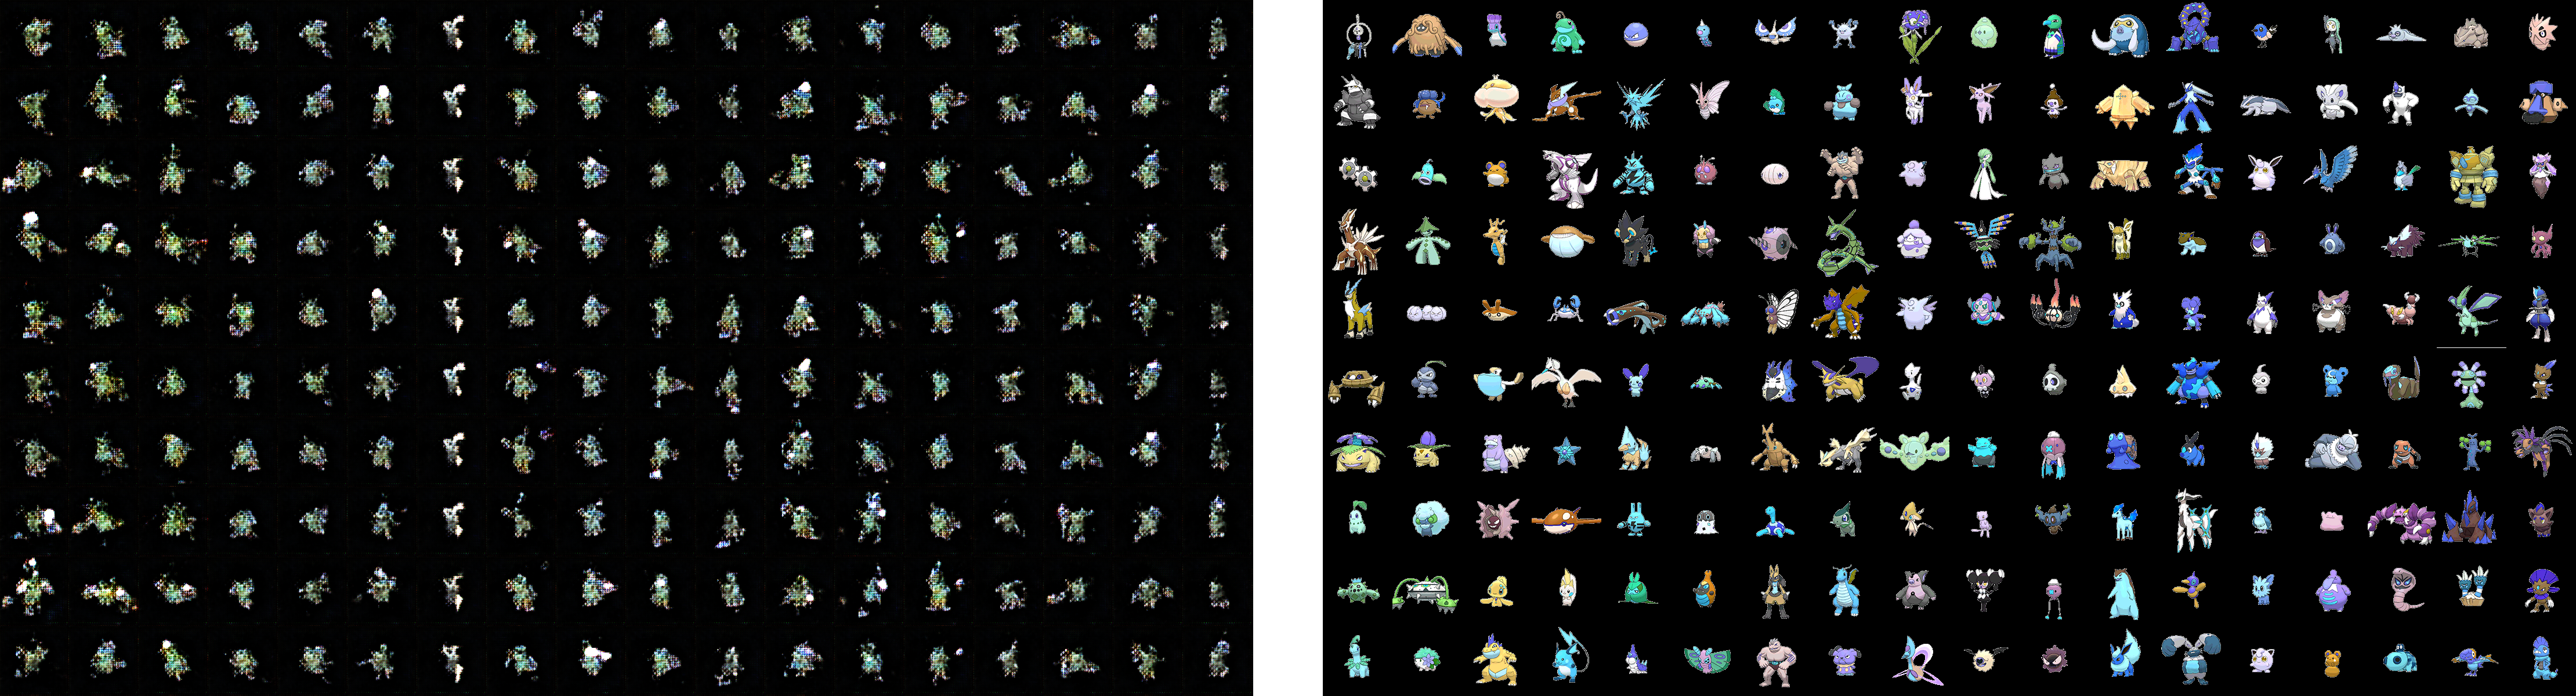

In [40]:
#!ls *.png
from IPython.display import Image
Image(filename='plot_pokemon_epoch_045_generated.png') 